In [1]:
# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
import pickle
import pathlib
import hashlib

from time import time


dask.config.set({'array.slicing.split_large_chunks': False})

# import torch
import torch
from torch.utils.data import Dataset, DataLoader


# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Dotenv
from dotenv import dotenv_values

from utils.data_process import *
from utils.utils_plot import *
from utils.utils_gans import *

# try and see if the performance improves --because I have HDF5 issues..
from dask.distributed import Client
c = Client(n_workers=os.cpu_count()-2, threads_per_worker=1)


/storage/homefs/no21h426/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Cuda Avaliable :", torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Cuda Avaliable : True
cuda


In [54]:
# Define paths and constant
config = dotenv_values(".env")

# Paths
PATH_low = config['PATH_ERA5_low1'] # We can start with a very low resolution (1) , then we can test with the original ERA5 0.25
PATH_high = config['PATH_MeteoS']     # Note that Meteoswiss has a different coordinate system, but it doesn't matter here, as we only care about tensors

# Some constants
G = 9.80665

# Options
#DATE_START = '1979-01-01'
#DATE_END = '2021-12-31'
#YY_TRAIN = [1979, 2015]
#YY_TEST = [2016, 2021]

# Options for testing
# Options
DATE_START = '1999-01-01'
DATE_END = '2021-12-31'
YY_TRAIN = [1999, 2015]
YY_TEST = [2016, 2021]

LEVELS = [300, 500, 700, 850, 1000]  
LONS = [-5, 18]
LATS = [40, 60]
# Alternatives to proceed with the NaN:
# 1. Crop the tensor
# 2. Create a mask (cons: information loss during the training)?
# 3. Fill the Nan (not a good option)
LONS_high_crop = [2700000, 2770000]
LATS_high_crop = [1190000, 1280000]
# to try with NAN
#LONS_high_crop = [2720000, 2770000]
#LATS_high_crop = [1290000, 1320000]
BATCH_SIZE = 32 # 32

In [5]:
# I will start using a small region

#### Read Targets

In [6]:
# Read precipitation high resolution
pr = get_nc_data(PATH_high + '/RhiresD_v2.0_swiss.lv95/*nc', DATE_START, DATE_END)

Extracting data for the period 1999-01-01 - 2021-12-31


In [7]:
TabsD = get_nc_data(PATH_high + '/TabsD_v2.0_swiss.lv95/*nc', DATE_START, DATE_END)

Extracting data for the period 1999-01-01 - 2021-12-31


In [8]:
TmaxD = get_nc_data(PATH_high + '/TmaxD_v2.0_swiss.lv95/*nc', DATE_START, DATE_END)

Extracting data for the period 1999-01-01 - 2021-12-31


In [9]:
TminD = get_nc_data(PATH_high + '/TminD_v2.0_swiss.lv95/*nc', DATE_START, DATE_END) 

Extracting data for the period 1999-01-01 - 2021-12-31


In [55]:
lon_lv95 = pr.E
lat_lv95 = pr.N

In [56]:
lonT_lv95 = TabsD.E
latT_lv95 = TabsD.N

In [57]:
pr_d1 = pr.sel(E=slice(np.nanmin(LONS_high_crop), np.nanmax(LONS_high_crop)), N = slice(np.nanmin(LATS_high_crop), np.nanmax(LATS_high_crop)))
TabsD_d1 = TabsD.sel(E=slice(np.nanmin(LONS_high_crop), np.nanmax(LONS_high_crop)), N = slice(np.nanmin(LATS_high_crop), np.nanmax(LATS_high_crop)))
TmaxD_d1 = TmaxD.sel(E=slice(np.nanmin(LONS_high_crop), np.nanmax(LONS_high_crop)), N = slice(np.nanmin(LATS_high_crop), np.nanmax(LATS_high_crop)))
TminD_d1 = TminD.sel(E=slice(np.nanmin(LONS_high_crop), np.nanmax(LONS_high_crop)), N = slice(np.nanmin(LATS_high_crop), np.nanmax(LATS_high_crop)))

In [58]:
# To keep the common latitudes
#pr_red = pr.sel(N=latT_lv95)

In [59]:
LONS_D1 = lon_lv95[np.logical_and(lon_lv95 >= LONS_high_crop[0], lon_lv95 < LONS_high_crop[1])]
LATS_D1 = lat_lv95[np.logical_and(lat_lv95 >= LATS_high_crop[0], lat_lv95 < LATS_high_crop[1])]


#### Visualize

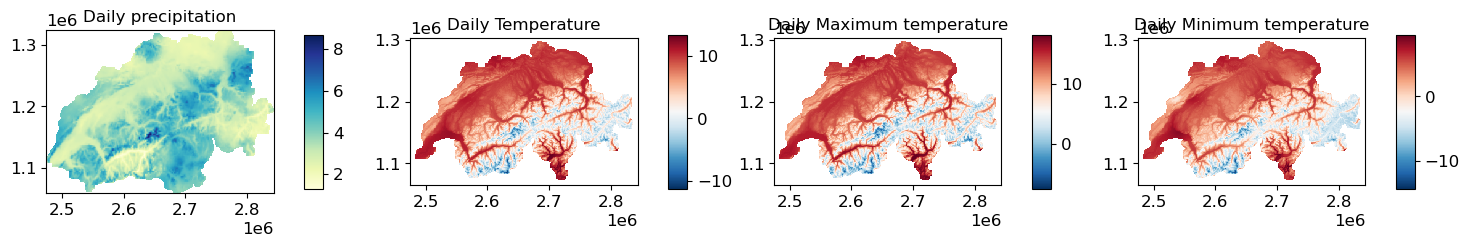

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(18,4))
plot_map(axs[0], lon_lv95, lat_lv95, pr.RhiresD.mean(dim='time').to_numpy().squeeze(), title="Daily precipitation", cmap=mpl.cm.YlGnBu)
plot_map(axs[1], lon_lv95, latT_lv95, TabsD.TabsD.mean(dim='time').to_numpy().squeeze(), title="Daily Temperature", cmap=mpl.cm.RdBu_r)
plot_map(axs[2], lon_lv95, latT_lv95, TmaxD.TmaxD.mean(dim='time').to_numpy().squeeze(), title="Daily Maximum temperature", cmap=mpl.cm.RdBu_r)
plot_map(axs[3], lon_lv95, latT_lv95, TminD.TminD.mean(dim='time').to_numpy().squeeze(), title="Daily Minimum temperature", cmap=mpl.cm.RdBu_r)

#### Visualize crop-domain

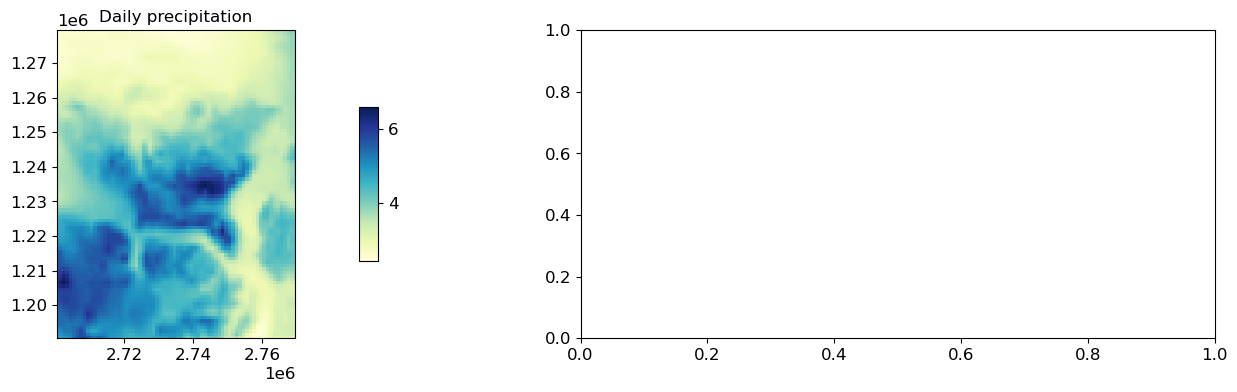

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(18,4))
plot_map(axs[0], LONS_D1, LATS_D1, pr_d1.RhiresD.mean(dim='time').to_numpy().squeeze(), title="Daily precipitation", cmap=mpl.cm.YlGnBu)
#plot_map(axs[1], LONS_D1, LATS_D1, TabsD_d1.TabsD.mean(dim='time').to_numpy().squeeze(), title="Daily Temperature", cmap=mpl.cm.RdBu_r)
#plot_map(axs[2], LONS_D1, LATS_D1, TmaxD_d1.TmaxD.mean(dim='time').to_numpy().squeeze(), title="Daily Maximum temperature", cmap=mpl.cm.RdBu_r)
#plot_map(axs[3], LONS_D1, LATS_D1, TminD_d1.TminD.mean(dim='time').to_numpy().squeeze(), title="Daily Minimum temperature", cmap=mpl.cm.RdBu_r)

#### Merge target

In [61]:
#dy = xr.merge([pr_d1,TabsD_d1, TmaxD_d1, TabsD_d1])

In [62]:
# For now just prec
dy = pr_d1.RhiresD
# All CH-domain
#dy = pr.RhiresD

In [64]:
# check NANs
np.isnan(dy.to_numpy()).sum()

0

In [65]:
# Open the predictors data
# load predictors
#l_paths = ['/precipitation/day_grid1/','/temperature/day_grid1/', '/U_wind/day_grid1/', '/V_wind/day_grid1/']
#v_vars = ['tp','t', 'u', 'v']
l_paths = ['/precipitation/day_grid1/','/temperature/day_grid1/']
v_vars = ['tp','t']
list_vars = load_data(v_vars, l_paths, G, PATH_low, DATE_START, DATE_END, LONS, LATS, LEVELS)
datasets = list_vars

Extracting data for the period 1999-01-01 - 2021-12-31
Extracting data for the period 1999-01-01 - 2021-12-31
select level


In [66]:
ds = xr.merge(datasets)

In [67]:
# Invert lat axis if needed
if ds.lat[0].values < ds.lat[1].values:
    ds = ds.reindex(lat=list(reversed(ds.lat)))
    
# Get axes
lats_x = ds.lat
lons_x = ds.lon

In [68]:
# Split the data
# only load a subset of the training data
#ds_train = ds.sel(time=slice('1979', '2011')) 
#ds_valid = ds.sel(time=slice('2012', '2015')) 
#ds_test = ds.sel(time=slice('2016', '2021'))

In [69]:
#dy_train = dy.sel(time=slice('1979', '2011'))
#dy_valid = dy.sel(time=slice('2012', '2015'))
#dy_test = dy.sel(time=slice('2016', '2021'))

In [70]:
ds_train = ds.sel(time=slice('1999', '2011')) 
ds_valid = ds.sel(time=slice('2012', '2015')) 
ds_test = ds.sel(time=slice('2016', '2021'))

dy_train = dy.sel(time=slice('1999', '2011'))
dy_valid = dy.sel(time=slice('2012', '2005'))
dy_test = dy.sel(time=slice('2006', '2011'))

In [71]:
dic = {#'z': LEVELS,
       'tp': None,
       't': LEVELS}
    #   'r': LEVELS,
    #   'tcwv': None,
     #  'u': LEVELS,
     #  'v': LEVELS}

In [72]:
dy_train

<xarray.DataArray 'RhiresD' (time: 4748, N: 90, E: 70)>
dask.array<getitem, shape=(4748, 90, 70), dtype=float32, chunksize=(366, 90, 70), chunktype=numpy.ndarray>
Coordinates:
  * E        (E) float64 2.7e+06 2.702e+06 2.702e+06 ... 2.768e+06 2.77e+06
  * N        (N) float64 1.19e+06 1.192e+06 1.192e+06 ... 1.278e+06 1.28e+06
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2011-12-31
    lon      (N, E) float32 dask.array<chunksize=(90, 70), meta=np.ndarray>
    lat      (N, E) float32 dask.array<chunksize=(90, 70), meta=np.ndarray>
Attributes:
    units:         millimeter
    grid_mapping:  swiss_lv95_coordinates
    long_name:     daily precipitation sum
    grid_name:     ch01h.swiss.lv95
    version:       v2.0
    prod_date:     2022-01-20 18:03:35

In [73]:
# create data generator in pytorch # Adapted from the keras class
class DataGenerator(Dataset):
    def __init__(self, ds, label, var_dict, batch_size=32, load=True, mean=None, std=None, lead_time=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all input variables
            label: output
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """
        self.ds = ds
        self.dy = label
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.lead_time = lead_time
                
        data = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        
        for var, levels in var_dict.items():
            if levels is None:
                data.append(ds[var].expand_dims({'level': generic_level}, 1)) 
            else:
                data.append(ds[var].sel(level=levels))

        # Change level position 
        
        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        
        # Normalize
        self.data = (self.data - self.mean) / self.std
        
        if self.lead_time is None: 
            self.n_samples = self.data.shape[0]
        else:
            self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
            self.init_time = self.data.isel(time=slice(None, -lead_time)).time
            self.valid_time = self.data.isel(time=slice(lead_time, None)).time
            
        self.idxs = np.arange(self.n_samples)
        

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()

        
    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        idxs = self.idxs[idx]
        
        X = (torch.Tensor(self.data.isel(time=idxs).values))
        
        if self.lead_time is None:
             y = (torch.Tensor(self.dy.isel(time=idxs).values))
        else:
             y = (torch.Tensor(self.dy.isel(time=idxs + self.lead_time).values))
                
        # In PyTorch we must transpose (C,H,W,B)
        X = torch.Tensor(X).permute(2, 0, 1)
        
        if y.ndim > 2:
            y = torch.Tensor(y).permute(2, 0, 1)
        else:
            # expand dimensions
            y = torch.unsqueeze(y, dim=0)

            
        return X, y    


In [74]:
training_set = DataGenerator(ds_train, dy_train, dic, batch_size=BATCH_SIZE, lead_time = None)
loader_train = torch.utils.data.DataLoader(training_set, batch_size=32)

Loading data into RAM


In [75]:
# Validation
valid_set = DataGenerator(ds_valid, dy_valid, dic, batch_size=BATCH_SIZE, mean=training_set.mean, std=training_set.std, lead_time = None)
loader_val = torch.utils.data.DataLoader(valid_set, batch_size=32)
# Test
test_set = DataGenerator(ds_test, dy_test, dic, batch_size=BATCH_SIZE, mean=training_set.mean, std=training_set.std, lead_time = None)
loader_test = torch.utils.data.DataLoader(test_set, batch_size=32)

Loading data into RAM
Loading data into RAM


In [76]:
# Check to make sure the range on the input and output images is correct, and they're the correct shape
testx, testy = training_set.__getitem__(3)
print("x shape: ", testx.shape)
print("y shape: ", testy.shape)
print("x min: ", torch.min(testx))
print("x max: ", torch.max(testx))
print("y min: ", torch.min(testy))
print("y max: ",torch.max(testy))

x shape:  torch.Size([6, 21, 24])
y shape:  torch.Size([1, 90, 70])
x min:  tensor(-1.7363)
x max:  tensor(6.9050)
y min:  tensor(0.)
y max:  tensor(8.4776)


In [77]:
data = next(iter(loader_train))
x, y = data
print('Shape of x:', x.shape)
print('Shape of y:', y.shape)

Shape of x: torch.Size([32, 6, 21, 24])
Shape of y: torch.Size([32, 1, 90, 70])


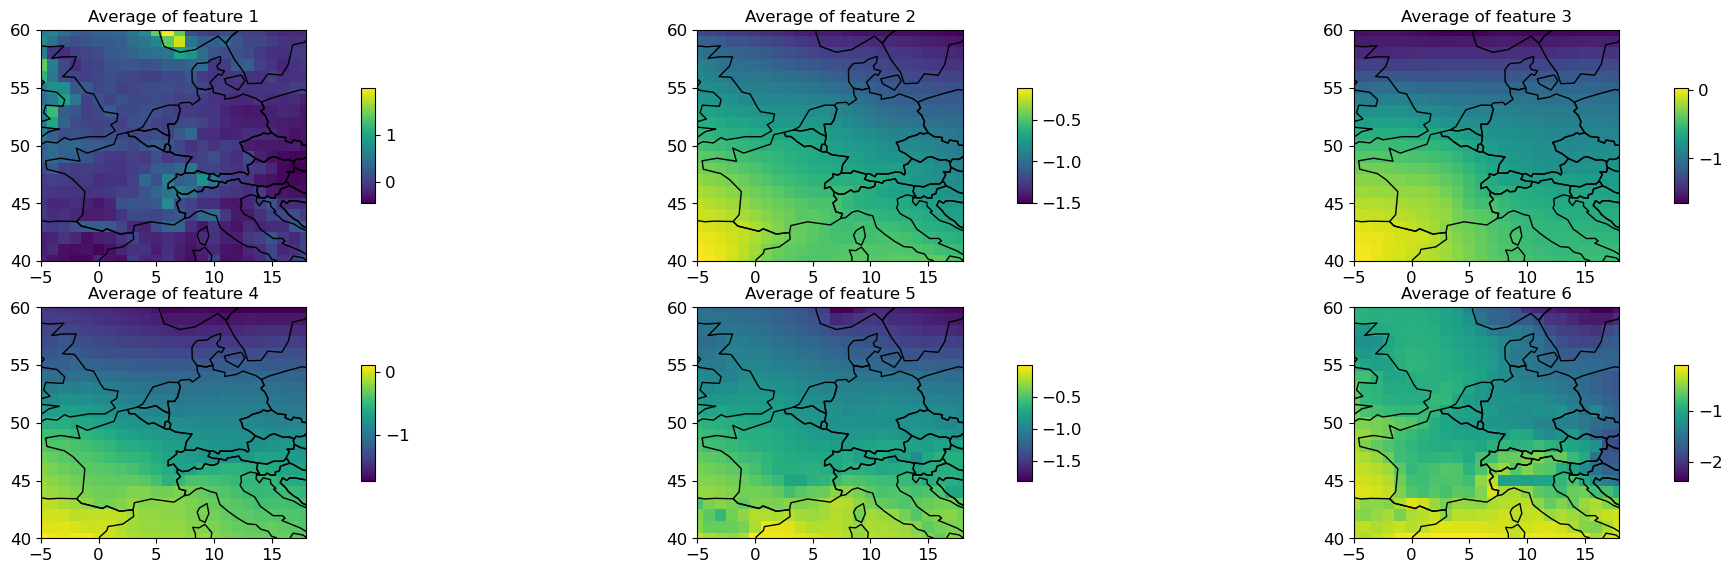

In [78]:
# Plot input
# Plotting the mean of the predictors
n_figs = len(x[0,:,0,0])
ncols = 3
nrows = -(-n_figs // ncols)
fig, axes = plt.subplots(figsize=(24, 3.3*nrows), ncols=ncols, nrows=nrows)
for i in range(n_figs):
    i_row = i // ncols
    i_col = i % ncols
    ax = axes[i_row, i_col]
    vals = torch.mean(x[:,i,:,:],axis=0)
    plot_map(ax, lons_x, lats_x, vals, title=f"Average of feature {i+1}")


In [79]:
# Defining the G and D
# Adapted from https://github.com/mantariksh/231n_downscaling/blob/master/SRGAN.ipynb

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, sampler, TensorDataset
from torch.utils.data import sampler

import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T


In [81]:
# Convenience 
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Discriminator(nn.Module):
    def __init__(self, num_channels, H, W):
        super().__init__()
        
        self.layers = nn.Sequential( 
            nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            Flatten(),  
            nn.Linear(512 * int(np.ceil(H/16)) * int(np.ceil(W/16)), 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
            
        )
        
    def forward(self, x):
        return self.layers(x)

In [82]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(num_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(num_channels)
        )

    def forward(self, x):
        return x + self.layers(x)


        
class UpscaleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(scale_factor),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.layers(x)

class Generator(nn.Module):
    def __init__(self, num_channels, input_size, num_res_blocks=16, scale_factor=4):
        super().__init__()
        
        self.num_res_blocks = num_res_blocks
        self.input_size = input_size
        self.initial_conv = nn.Sequential(
            nn.ReflectionPad2d(4),
            nn.Conv2d(num_channels, 64, kernel_size=9, stride=1, padding=0),
            nn.PReLU()
        )
        
        self.resBlocks = nn.ModuleList([ResidualBlock(64) for i in range(self.num_res_blocks)])

        self.post_resid_conv = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),
            nn.BatchNorm2d(64)
        )

        self.upscale_blocks = nn.ModuleList()
        for _ in range(int(math.log(scale_factor, 2))):
            self.upscale_blocks.append(UpscaleBlock(64, 64 * 4, scale_factor=2))

        self.conv_prelu = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),
            nn.PReLU()
        )
    
        self.final_conv = nn.Sequential(
            nn.ReflectionPad2d(4),
            nn.Conv2d(64, 1, 9, stride=1, padding=0)
        )

    def forward(self, x):
        initial_conv_out = self.initial_conv(x)
                
        res_block_out = self.resBlocks[0](initial_conv_out)
        for i in range(1, self.num_res_blocks):
            res_block_out = self.resBlocks[i](res_block_out)

        post_resid_conv_out = self.post_resid_conv(res_block_out) + initial_conv_out

        upscale_out = post_resid_conv_out
        for block in self.upscale_blocks:
            upscale_out = block(upscale_out)

        conv_prelu_out = self.conv_prelu(upscale_out)
        final_out = self.final_conv(conv_prelu_out)
        # To get the final desired shape
        final_out = F.interpolate(final_out, size=self.input_size, mode='bicubic', align_corners=True)

        return final_out


In [83]:
### Test the Generator

In [84]:
NUM_CHANNELS_IN = 6
dtype = torch.float32 
input_size=y.shape[2:]


In [85]:
print(input_size)

torch.Size([90, 70])


### Check the generator

In [86]:
x,y = (training_set.__getitem__(3))

In [87]:
x = x.unsqueeze(0)
print(x.shape)

torch.Size([1, 6, 21, 24])


In [88]:
model = Generator(NUM_CHANNELS_IN,input_size)
model = model.to(device=device)
x = x.to(device=device, dtype=dtype)
    

In [89]:
output = model(x)

In [90]:
output.shape

torch.Size([1, 1, 90, 70])

<Figure size 640x480 with 0 Axes>

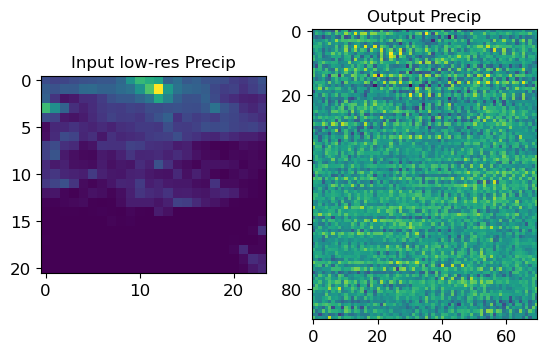

<Figure size 640x480 with 0 Axes>

In [91]:
plt.subplot(121)
plt.imshow(x.cpu().detach().numpy()[0, 0, :, :])
plt.title("Input low-res Precip")
plt.subplot(122)
plt.imshow(output.cpu().detach().numpy()[0, 0, :, :])
plt.title("Output Precip")
plt.figure()

### Check the discriminator

In [92]:
x,y = (training_set.__getitem__(3))

In [93]:
print(x.shape)

torch.Size([6, 21, 24])


In [94]:
y = y.unsqueeze(0)
print(y.shape)

torch.Size([1, 1, 90, 70])


In [95]:
h, w = y.shape[2:]

In [96]:
#### Test the discriminator
def test_Discriminator():
    x,y = (training_set.__getitem__(3))
    y = y.unsqueeze(0)
    print("y: ", y.shape)
    model = Discriminator(num_channels=1, H=h,W=w)
    output = model(y)
    print(output.size())
    print(output)
#test_Discriminator()


def test_withnan_Discriminator():
    x, y = training_set.__getitem__(3)
    y = y.unsqueeze(0)
    print("y shape:", y.shape)

    # Replace NaN values with a valid value
    y = torch.where(torch.isnan(y), torch.zeros_like(y), y)

    model = Discriminator(num_channels=1, H=h, W=w)
    output = model(y)
    print("Output size:", output.size())
    print(output)

test_withnan_Discriminator()

y shape: torch.Size([1, 1, 90, 70])
Output size: torch.Size([1, 1])
tensor([[0.5780]], grad_fn=<SigmoidBackward0>)


In [97]:
def generator_withNan_loss(gen_img, true_img, logits_fake, weight_param=1e-3):
    """
    Computes the generator loss described above.

    Inputs:
    - gen_img: (PyTorch tensor) shape N, C image generated by the Generator, so that we can calculate MSE
    - true_img: (PyTorch tensor) the true, high res image, so that we can calculate the MSE
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    - weight_param: how much to weight the adversarial loss by when summing the losses. Default in Ledig paper is 1e-3
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    #
    if torch.isnan(gen_img).any() or torch.isnan(true_img).any() or torch.isnan(logits_fake).any():
        # Handle NaN values here
        # Replace NaN values in gen_img and true_img with zeros
        gen_img = torch.where(torch.isnan(gen_img), torch.zeros_like(gen_img), gen_img)
        true_img = torch.where(torch.isnan(true_img), torch.zeros_like(true_img), true_img)

    
    # Content loss - MSE loss
    content_loss_func = nn.MSELoss()
    content_loss = content_loss_func(gen_img, true_img)
        
    N = logits_fake.shape[0]
    desired_labels = torch.ones(N, 1).to(device=device, dtype=dtype)
    BCE_Loss = nn.BCELoss()
    adversarial_loss = BCE_Loss(logits_fake, desired_labels)
    
    total_loss = content_loss + weight_param * adversarial_loss
    
    return total_loss, content_loss, adversarial_loss


In [55]:
def generator_withNaN_loss(gen_img, true_img, logits_fake, weight_param=1e-3):
    """
    Computes the generator loss described above.

    Inputs:
    - gen_img: (PyTorch tensor) shape N, C image generated by the Generator, so that we can calculate MSE
    - true_img: (PyTorch tensor) the true, high res image, so that we can calculate the MSE
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    - weight_param: how much to weight the adversarial loss by when summing the losses. Default in Ledig paper is 1e-3
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    # Handle NaN values in gen_img and true_img
    gen_img = torch.where(torch.isnan(gen_img), torch.zeros_like(gen_img), gen_img)
    true_img = torch.where(torch.isnan(true_img), torch.zeros_like(true_img), true_img)
    
    # Content loss - MSE loss
    content_loss_func = nn.MSELoss()
    content_loss = content_loss_func(gen_img, true_img)
        
    N = logits_fake.shape[0]
    desired_labels = torch.ones(N, 1).to(device=device, dtype=dtype)
    BCE_Loss = nn.BCELoss()
    adversarial_loss = BCE_Loss(logits_fake, desired_labels)
    
    total_loss = content_loss + weight_param * adversarial_loss
    
    return total_loss, content_loss, adversarial_loss


In [98]:
def discriminator_with_Nan_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data (real numbers). 
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data (real numbers).
    
    Returns:
    - loss: PyTorch Tensor containing the loss for the discriminator.
    """
    # Handle NaN values
    if torch.isnan(logits_real).any() or torch.isnan(logits_fake).any():
        # Replace NaN values with zeros
        logits_real = torch.where(torch.isnan(logits_real), torch.zeros_like(logits_real), logits_real)
        logits_fake = torch.where(torch.isnan(logits_fake), torch.zeros_like(logits_fake), logits_fake)

    N = logits_real.shape[0]
    real_labels = torch.ones(N, 1).to(device=logits_real.device, dtype=logits_real.dtype)
    fake_labels = torch.zeros(N, 1).to(device=logits_fake.device, dtype=logits_fake.dtype)
    
    BCE_Loss = nn.BCELoss()
    L1 = BCE_Loss(logits_real, real_labels)
    L2 = BCE_Loss(logits_fake, fake_labels)
    
    loss = L1 + L2
    return loss, L1, L2




In [99]:
import torch
import numpy as np

def check_generator_with_nan_accuracy(loader, model):
    model.eval()
    count, rmse_precip_ypred, rmse_precip_x = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            model = model.to(device=device)
            y = y.to(device=device, dtype=dtype)
            
            x_np = x.numpy()
            x_min = np.amin(x_np, axis=(2,3))[:, :, np.newaxis, np.newaxis]
            x_max = np.amax(x_np, axis=(2,3))[:, :, np.newaxis, np.newaxis]
            is_nan = np.int((x_min == x_max).any())
            eps = 1e-9
            x_norm_np = (x_np - x_min) / ((x_max - x_min + is_nan*eps) / 2) - 1
            x_norm_np[np.isnan(x_norm_np)] = 0  # Replace NaN values with zeros
            
            x_norm = torch.from_numpy(x_norm_np)
            x_norm = x_norm.to(device=device, dtype=dtype)
            x = x.to(device=device, dtype=dtype)
            
            y_predicted = model(x)
            y_predicted[np.isnan(y_predicted)] = 0  # Replace NaN values with zeros
            
            rmse_precip_ypred += torch.sqrt(torch.mean((y_predicted[:,0,:,:]-y[:,0,:,:]).pow(2)))
            rmse_precip_x += torch.sqrt(torch.mean((x_norm[:,0,:,:]-y[:,0,:,:]).pow(2)))
            count += 1
            
        rmse_precip_ypred /= count
        rmse_precip_x /= count
        print('RMSEs: \tInput precip: %.3f\n\tOutput precip: %.3f\n\t' % 
              (rmse_precip_x, rmse_precip_ypred))
        
        
def check_discriminator_with_nan_accuracy(loader, D, G):
    D = D.to(device=device)
    G = G.to(device=device)
    D.eval()
    G.eval()
    
    count, avg_true_pred, avg_fake_pred = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype)
            
            true_pred = D(y)
            true_pred[np.isnan(true_pred)] = 0  # Replace NaN values with zeros
            avg_true_pred += true_pred.sum()
            count += len(true_pred)
            
            fake_imgs = G(x)
            fake_pred = D(fake_imgs)
            fake_pred[np.isnan(fake_pred)] = 0  # Replace NaN values with zeros
            avg_fake_pred += fake_pred.sum()
            
        avg_true_pred /= count
        avg_fake_pred /= count
        print("Average prediction score on real data: %f" % (avg_true_pred))
        print("Average prediction score on fake data: %f" % (avg_fake_pred))


In [108]:

# Helper functions for plotting
def plot_epoch(x, y_pred, y):
    figsize = (9,4)
    plt.figure(figsize=figsize)
    plt.subplot(1,3,1)
    plt.imshow(x[0,0,:,:].cpu().detach().numpy())
    plt.title("Input Precip")
    plt.subplot(1,3,2)
    plt.imshow(y_pred[0,0,:,:].cpu().detach().numpy())
    plt.title("Output Precip")
    plt.subplot(1,3,3)
    plt.imshow(y[0,0,:,:].cpu().detach().numpy())
    plt.title("True Precip")
    
    
def plot_loss(G_content, G_advers, D_real_L, D_fake_L, weight_param):
    
    D_count = np.count_nonzero(D_real_L)
    G_count = np.count_nonzero(G_content)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(range(G_count), G_content[range(G_count)])
    plt.plot(range(G_count), G_advers[range(G_count)])
    plt.plot(range(G_count), G_content[range(G_count)] + weight_param*G_advers[range(G_count)])
    plt.legend(("Content", "Adversarial", "Total"))
    plt.title("Generator loss")
    plt.xlabel("Iteration")
    
    plt.subplot(1,2,2)
    plt.plot(range(D_count), D_real_L[range(D_count)])
    plt.plot(range(D_count), D_fake_L[range(D_count)])
    plt.plot(range(D_count), D_real_L[range(D_count)] + D_fake_L[range(D_count)])
    plt.legend(("Real Pic", "Fake Pic", "Total"))
    plt.title("Discriminator loss")
    plt.xlabel("Iteration")
    plt.show()

In [109]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [102]:
D = Discriminator(num_channels=1, H=h,W=w) 
G = Generator(NUM_CHANNELS_IN, input_size)

lr = 0.0002
# No checkpoints....
# Define optimizer for discriminator
D_solver = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
# Define optimizer for generator
G_solver = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))


In [103]:
num_epochs=2
G_iters=1
dtype = torch.float32

In [104]:
# Move the models to the correct device (GPU if GPU is available)
D = D.to(device=device)
G = G.to(device=device)
    
# Put models in training mode
D.train()
G.train()
    
print("Expected num iters: ", len(loader_train)*num_epochs)
G_content = np.zeros(len(loader_train)*num_epochs*G_iters+1)
G_advers = np.zeros(len(loader_train)*num_epochs*G_iters+1)
D_real_L = np.zeros(len(loader_train)*num_epochs+1)
D_fake_L = np.zeros(len(loader_train)*num_epochs+1)

Expected num iters:  298


In [71]:
#high_res_imgs = y.to(device=device, dtype=dtype)
#logits_real = D(high_res_imgs)

#x.requires_grad_()
#low_res_imgs = x.to(device=device, dtype=dtype)
#fake_images = G(low_res_imgs)
#logits_fake = D(fake_images)

In [72]:
#fake_images.shape

In [73]:
#logits_fake.shape

In [74]:
#d_total_error, D_real_L[iter_count], D_fake_L[iter_count] = discriminator_loss(logits_real, logits_fake)

In [75]:
#discriminator_loss(logits_real, logits_fake)

In [68]:
###################TEST
#iter_count = 0
#G_iter_count = 0
#show_every=40
#tic = time()
#for epoch in range(num_epochs):
#    for x,y in loader_train:
#        high_res_imgs = y.to(device=device, dtype=dtype)
#        logits_real = D(high_res_imgs)

#       x.requires_grad_()
#        low_res_imgs = x.to(device=device, dtype=dtype)
#        fake_images = G(low_res_imgs)
#        logits_fake = D(fake_images)

In [69]:
#d_total_error, D_real_L[iter_count], D_fake_L[iter_count] = discriminator_with_Nan_loss(logits_real, logits_fake)

d_total_error: tensor(0.3483, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.3482350707054138
D_fake_L[iter_count]: 3.436083352426067e-05
Epoch: 0, Iter: 0, D: 0.3483, G: 66.0, Time since last print (min): 0.04502


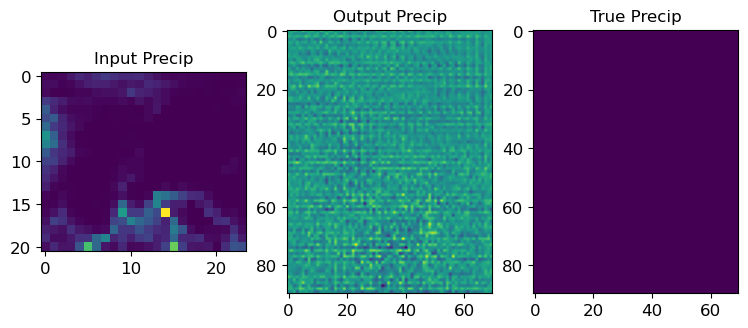

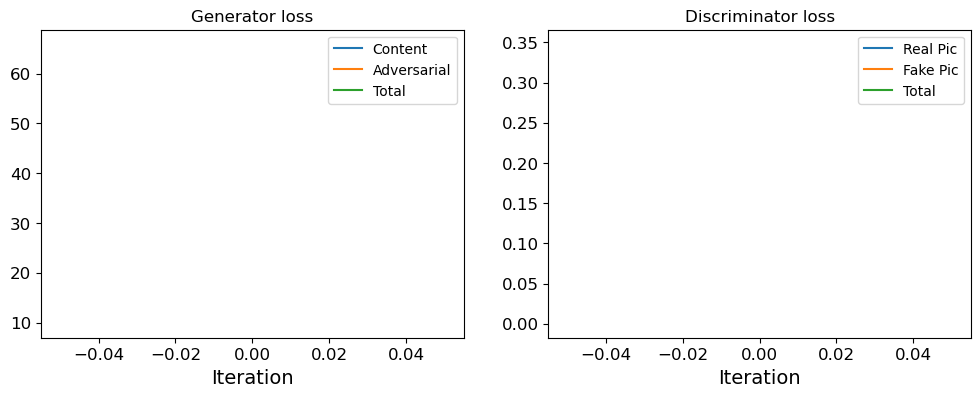


d_total_error: tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.000684772152453661
D_fake_L[iter_count]: 0.0008540905546396971
d_total_error: tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.00028142728842794895
D_fake_L[iter_count]: 0.09566172957420349
d_total_error: tensor(0.0073, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.007347827311605215
D_fake_L[iter_count]: 1.3783576946480025e-07
d_total_error: tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.00010535040200920776
D_fake_L[iter_count]: 2.7939679014821195e-08
d_total_error: tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.00010375577403465286
D_fake_L[iter_count]: 1.9427425286266953e-06
d_total_error: tensor(0.2406, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 9.504716581432149e-05
D_fake_L[iter_count]: 0.24052739143371582
d_total_error: tensor(8.3658, device='cuda:0'

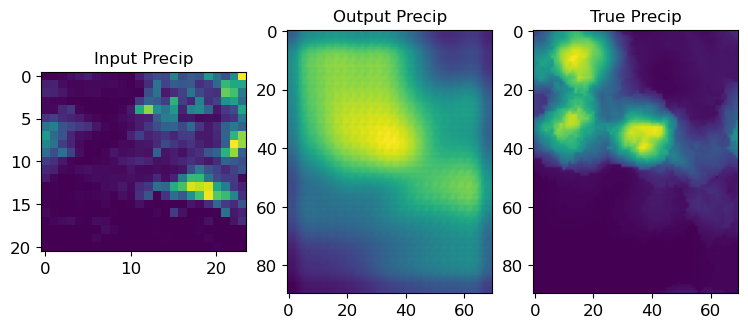

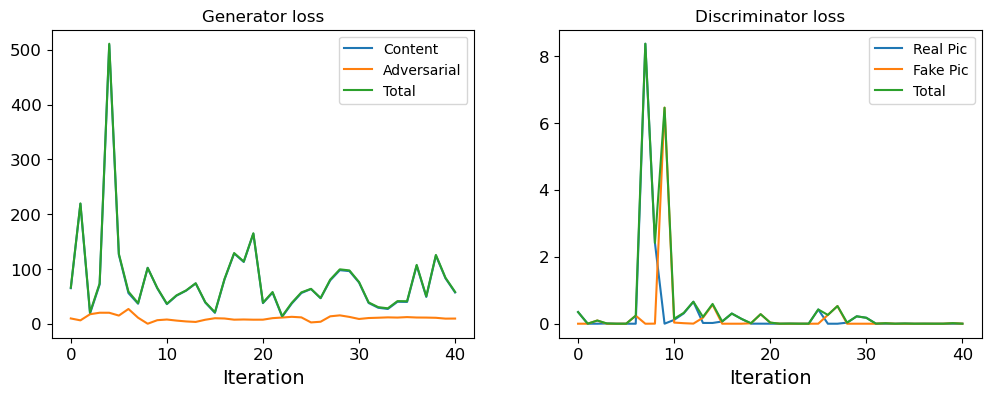


d_total_error: tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.00017703008779790252
D_fake_L[iter_count]: 0.0005056371446698904
d_total_error: tensor(0.0196, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 2.373389361309819e-05
D_fake_L[iter_count]: 0.01959383487701416
d_total_error: tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.00011193474347237498
D_fake_L[iter_count]: 3.317679147585295e-05
d_total_error: tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.0009880723664537072
D_fake_L[iter_count]: 3.5688444768311456e-06
d_total_error: tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.00010146826389245689
D_fake_L[iter_count]: 1.4919813793312642e-06
d_total_error: tensor(4.9350e-05, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 4.8824382247403264e-05
D_fake_L[iter_count]: 5.25266273143643e-07
d_total_error: tensor(0.0018, device='

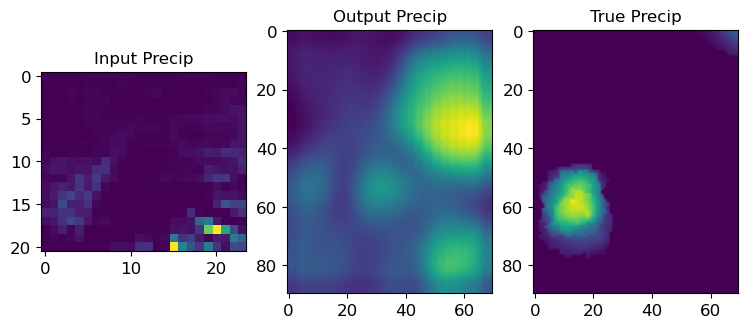

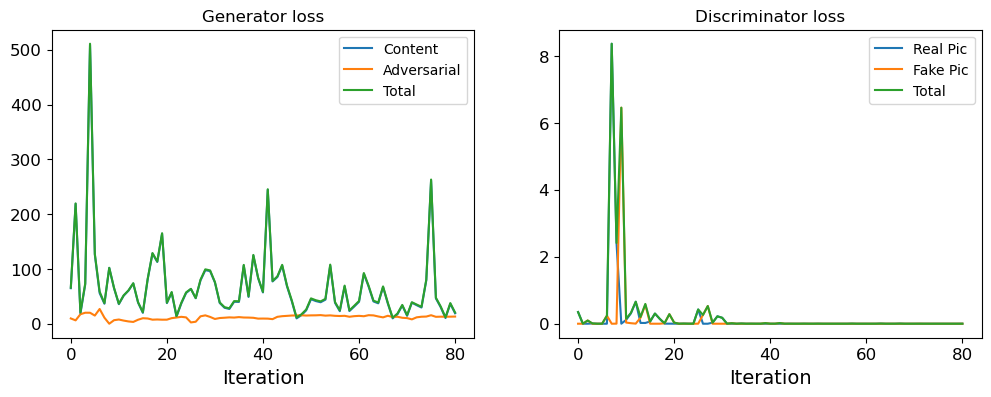


d_total_error: tensor(2.8637e-05, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 1.4666749848402105e-05
D_fake_L[iter_count]: 1.397016785631422e-05
d_total_error: tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.00018955522682517767
D_fake_L[iter_count]: 6.925656634848565e-05
d_total_error: tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 1.3396560461842455e-05
D_fake_L[iter_count]: 0.0001843357749748975
d_total_error: tensor(0.4273, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 6.116964868851937e-06
D_fake_L[iter_count]: 0.427263468503952
d_total_error: tensor(9.4622, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 9.461828231811523
D_fake_L[iter_count]: 0.0003608853439800441
d_total_error: tensor(3.3192, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.2901028096675873
D_fake_L[iter_count]: 3.0291035175323486
d_total_error: tensor(1.4702, device='cuda:0', grad_

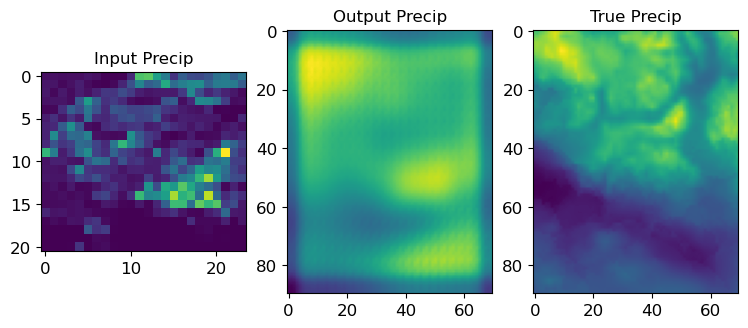

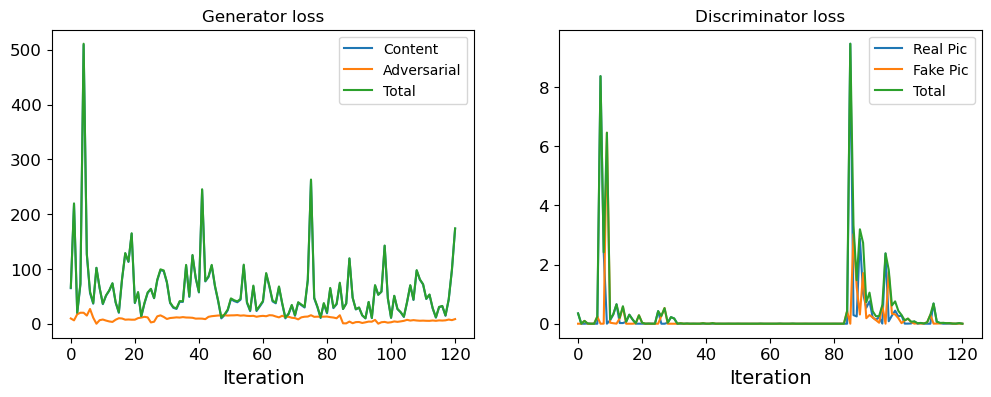


d_total_error: tensor(0.0047, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.00021555236889980733
D_fake_L[iter_count]: 0.004454147536307573
d_total_error: tensor(0.0109, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.0022283645812422037
D_fake_L[iter_count]: 0.008705261163413525
d_total_error: tensor(0.0220, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 1.9882729247910902e-05
D_fake_L[iter_count]: 0.021950699388980865
d_total_error: tensor(0.0034, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.002323585096746683
D_fake_L[iter_count]: 0.0010704335290938616
d_total_error: tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.002074269577860832
D_fake_L[iter_count]: 0.0003025777987204492
d_total_error: tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.0004991900059394538
D_fake_L[iter_count]: 0.004468683153390884
d_total_error: tensor(0.0033, device='cuda:0', gr

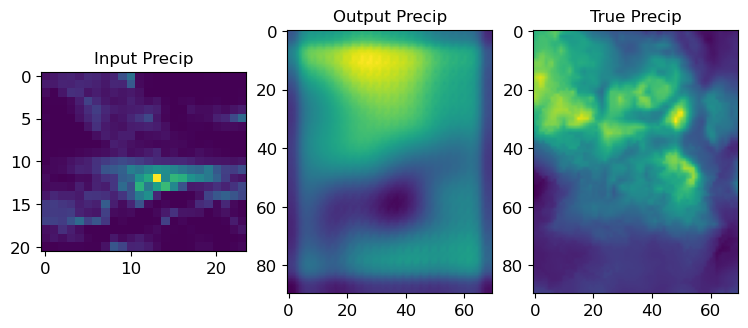

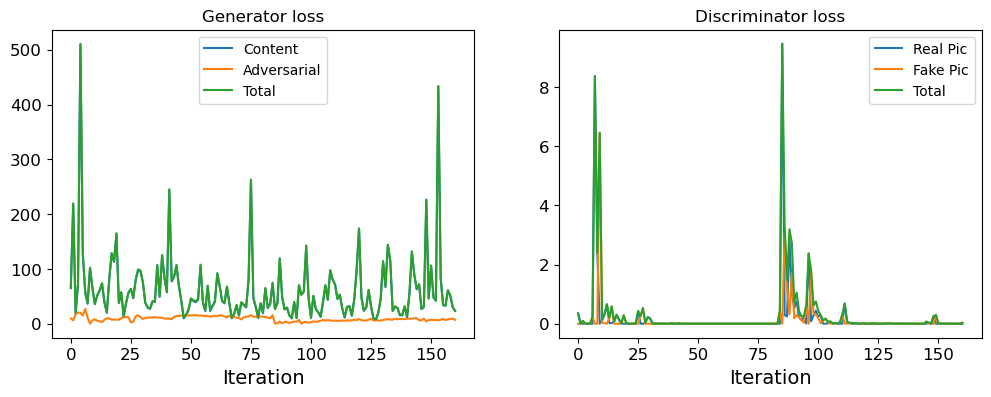


d_total_error: tensor(0.0159, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 6.1394380281853955e-06
D_fake_L[iter_count]: 0.015886269509792328
d_total_error: tensor(0.0068, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 3.9488119796260435e-07
D_fake_L[iter_count]: 0.006757995113730431
d_total_error: tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 5.2029514336027205e-05
D_fake_L[iter_count]: 0.00010521024523768574
d_total_error: tensor(5.6270e-05, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 1.4427254427573644e-05
D_fake_L[iter_count]: 4.184308272670023e-05
d_total_error: tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.0002888517046812922
D_fake_L[iter_count]: 0.0001437504106434062
d_total_error: tensor(0.4806, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.4799787998199463
D_fake_L[iter_count]: 0.0006574511644430459
d_total_error: tensor(13.9753, device='cu

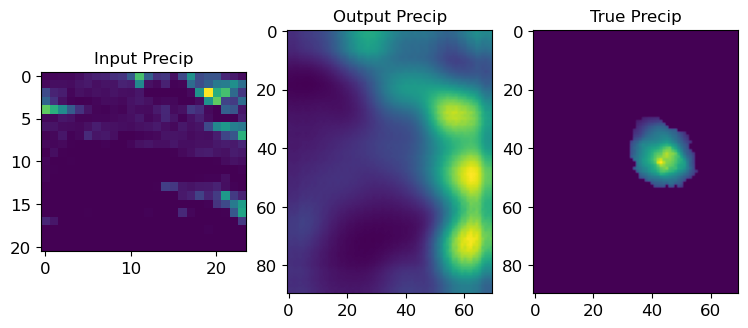

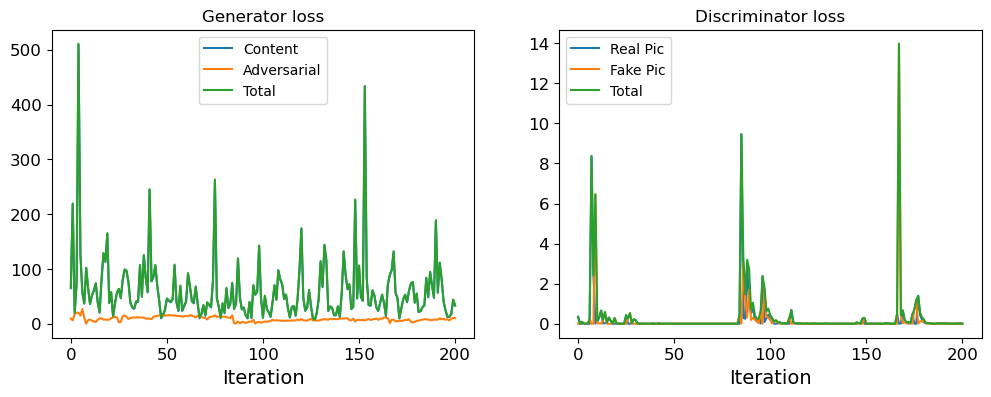


d_total_error: tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.0004771850653924048
D_fake_L[iter_count]: 9.242931264452636e-05
d_total_error: tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 4.413830174598843e-05
D_fake_L[iter_count]: 0.0014644423499703407
d_total_error: tensor(0.0032, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 8.128774425131269e-06
D_fake_L[iter_count]: 0.003210547147318721
d_total_error: tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.00021647673565894365
D_fake_L[iter_count]: 0.002241333946585655
d_total_error: tensor(0.0109, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 8.466228609904647e-05
D_fake_L[iter_count]: 0.010834453627467155
d_total_error: tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.0628526359796524
D_fake_L[iter_count]: 0.003825425636023283
d_total_error: tensor(0.0051, device='cuda:0', grad

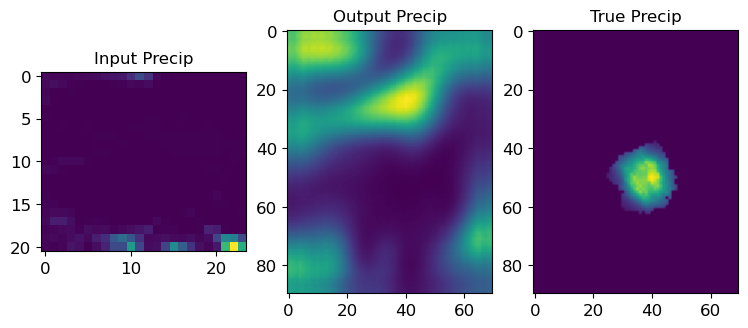

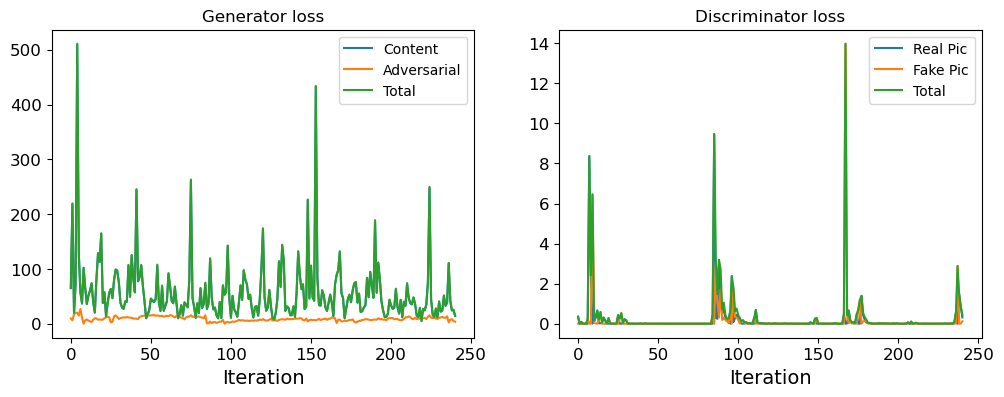


d_total_error: tensor(0.1901, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.04699186235666275
D_fake_L[iter_count]: 0.14314351975917816
d_total_error: tensor(0.3167, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.07845955342054367
D_fake_L[iter_count]: 0.2382803112268448
d_total_error: tensor(0.1937, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.12283702939748764
D_fake_L[iter_count]: 0.07082094997167587
d_total_error: tensor(0.1620, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.06835395842790604
D_fake_L[iter_count]: 0.09360792487859726
d_total_error: tensor(0.2036, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.18895915150642395
D_fake_L[iter_count]: 0.014656879007816315
d_total_error: tensor(0.1256, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.0061241863295435905
D_fake_L[iter_count]: 0.11945818364620209
d_total_error: tensor(0.0315, device='cuda:0', grad_fn=<AddBackward

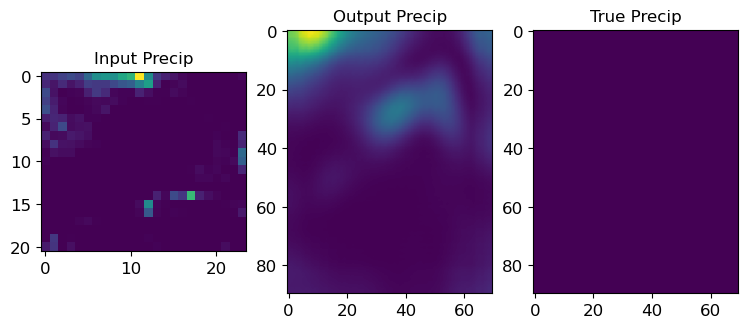

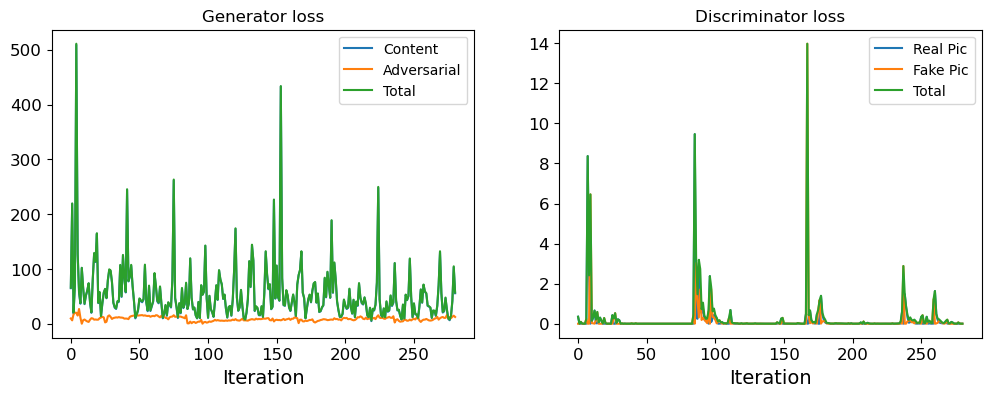


d_total_error: tensor(0.0073, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.007326856255531311
D_fake_L[iter_count]: 1.7892325558932498e-05
d_total_error: tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.0003367091412656009
D_fake_L[iter_count]: 0.0004703878075815737
d_total_error: tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.0013972560409456491
D_fake_L[iter_count]: 2.8372840461088344e-05
d_total_error: tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.0006859781569801271
D_fake_L[iter_count]: 5.345805220713373e-07
d_total_error: tensor(0.0098, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.009811891242861748
D_fake_L[iter_count]: 4.360497314337408e-06
d_total_error: tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
D_real_L[iter_count]: 0.0007022572681307793
D_fake_L[iter_count]: 7.914190791780129e-05
d_total_error: tensor(0.0072, device='cuda:0'

In [110]:
iter_count = 0
G_iter_count = 0
show_every=40
tic = time()
for epoch in range(num_epochs):
    for x,y in loader_train:
        high_res_imgs = y.to(device=device, dtype=dtype)
        logits_real = D(high_res_imgs)

        x.requires_grad_()
        low_res_imgs = x.to(device=device, dtype=dtype)
        fake_images = G(low_res_imgs)
        logits_fake = D(fake_images)
    
        # Update for the discriminator
        #d_total_error, D_real_L[iter_count], D_fake_L[iter_count] = discriminator_with_Nan_loss(logits_real, logits_fake)
        d_total_error, D_real_L[iter_count], D_fake_L[iter_count] = discriminator_loss(logits_real, logits_fake)
        #print('d_total_error:', d_total_error)
        #print('D_real_L[iter_count]:', D_real_L[iter_count])
        #print('D_fake_L[iter_count]:', D_fake_L[iter_count])
        D_solver.zero_grad()
        d_total_error.backward()
        D_solver.step()
        
        for i in range(G_iters):
                # Update for the generator
                fake_images = G(low_res_imgs)
                logits_fake = D(fake_images)
                gen_logits_fake = D(fake_images)
                weight_param = 1e-1 # Weighting put on adversarial loss
                g_error, G_content[G_iter_count], G_advers[G_iter_count] = generator_loss(fake_images, high_res_imgs, gen_logits_fake, weight_param=weight_param)
                #g_error, G_content[G_iter_count], G_advers[G_iter_count] = generator_withNan_loss(fake_images, high_res_imgs, gen_logits_fake, weight_param=weight_param)
                
                G_solver.zero_grad()
                g_error.backward()
                G_solver.step()
                G_iter_count += 1
                
        if (iter_count % show_every == 0):
                toc = time()
                print('Epoch: {}, Iter: {}, D: {:.4}, G: {:.4}, Time since last print (min): {:.4}'.format(epoch,iter_count,d_total_error.item(),g_error.item(), (toc-tic)/60 ))
                tic = time()
                plot_epoch(x, fake_images, y)
                plot_loss(G_content, G_advers, D_real_L, D_fake_L, weight_param)
                print()
        iter_count += 1
        
        D = D.to(device=device)
        G = G.to(device=device)
        # Put models in training mode
        D.train()
        G.train()